In [1]:
import gym
import matplotlib.pyplot as plt
import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer
from scouting_gym.tasks.scouting_discrete_task import ScoutingDiscreteTask

Instructions for updating:
non-resource variables are not supported in the long term
None


## Register Environment

In [2]:
env = gym.make('Scouting-v0')

print("Observation Space: {}".format(env.observation_space))
print("Action Space: {}".format(env.action_space))

[ERROR] [1614083071.792531, 0.000000]: NOT Initialising Simulation Physics Parameters
[WARN] [1614083071.795765, 0.000000]: Start Init ControllersConnection
[WARN] [1614083071.796618, 0.000000]: END Init ControllersConnection


Observation Space: Box(0.0, 1.0, (84, 84, 4), float32)
Action Space: Discrete(3)


## Check Environment State

0.0
1.0


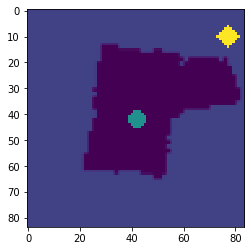

In [3]:
obs = env.reset()
for _ in range(1):
    obs, _, _, _ = env.step(action=2)
plt.imshow(obs[:, :, 0])
print(obs.min())
print(obs.max())

## Ray Configs

In [4]:
config = {
    "env": ScoutingDiscreteTask,  # or "corridor" if registered above
    "env_config": {
        "corridor_length": 5,
    },
    "num_gpus": 1,
    "num_workers": 1,
    #"model": {"dim": 84,
    #          "conv_filters":
    #              [[16, [3, 3], 2], [32, [3, 3], 2], [64, [3, 3], 2], [128, [11, 11], 1]]}
}

stop = {
    "episodes_total": 6000,
}

In [5]:
ray.init()

2021-02-23 13:24:36,177	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.178.60',
 'raylet_ip_address': '192.168.178.60',
 'redis_address': '192.168.178.60:6379',
 'object_store_address': '/tmp/ray/session_2021-02-23_13-24-35_630430_67907/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-23_13-24-35_630430_67907/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-02-23_13-24-35_630430_67907',
 'metrics_export_port': 62252,
 'node_id': '347965b06058f3837391520507b72ab829d27fda'}

## Train

In [6]:
def train(stop_criteria, config, restorepath):
    """
    Train an RLlib PPO agent using tune until any of the configured stopping criteria is met.
    :param stop_criteria: Dict with stopping criteria.
        See https://docs.ray.io/en/latest/tune/api_docs/execution.html#tune-run
    :return: Return the path to the saved agent (checkpoint) and tune's ExperimentAnalysis object
        See https://docs.ray.io/en/latest/tune/api_docs/analysis.html#experimentanalysis-tune-experimentanalysis
    """
    analysis = ray.tune.run(PPOTrainer, config=config,
                            stop=stop_criteria,
                            checkpoint_freq=1,
                            checkpoint_at_end=True)
    # list of lists: one list per checkpoint; each checkpoint list contains 1st the path, 2nd the metric value
    checkpoints = analysis.get_trial_checkpoints_paths(trial=analysis.get_best_trial('episode_reward_mean', mode='max'),
                                                       metric='episode_reward_mean',
                                                       )
    # retriev the checkpoint path; we only have a single checkpoint, so take the first one
    checkpoint_path = checkpoints[0][0]
    return checkpoint_path, analysis

def load(checkpoint_path, config):
    """
    Load a trained RLlib agent from the specified path. Call this before testing a trained agent.
    :param path: Path pointing to the agent's saved checkpoint (only used for RLlib agents)
    """
    agent = PPOTrainer(config=config)
    agent.restore(checkpoint_path)
    return agent

def test(agent, env):
    """Test trained agent for a single episode. Return the episode reward"""
    # instantiate env class

    # run until episode ends
    episode_reward = 0
    done = False
    obs = env.reset()
    while not done:
        action = agent.compute_action(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward

    return episode_reward

def test_traj(agent, env):
    """Test trained agent for a single episode. Return the episode reward"""
    # instantiate env class

    # run until episode ends
    episode_reward = 0
    done = False
    obs = env.reset()
    positions = []
    while not done:
        action = agent.compute_action(obs)
        obs, reward, done, info = env.step(action)
        positions.append(info['position'])
        episode_reward += reward

    return episode_reward, positions

In [7]:
checkpoint_path, analysis = train(stop_criteria=stop,
                                  config=config,
                                  restorepath='/home/dschori/ray_results/'
                                              'PPO_2021-02-09_17-09-27/' \
                  'PPO_ScoutingDiscreteTask_2f1df_00000_0_2021-02-09_17-09-27/' \
                  'checkpoint_201/checkpoint-201')

Trial name,status,loc
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,


(pid=84297) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=84297) Instructions for updating:
(pid=84297) non-resource variables are not supported in the long term
(pid=84297) 2021-02-20 14:08:50,275	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=84297) 2021-02-20 14:08:50,275	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=84296) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=84296) Instructions for updating:
(pid=84296) non-resource variables a

(pid=84297) None
(pid=84296) None
Result for PPO_ScoutingDiscreteTask_c4001_00000:
  custom_metrics: {}
  date: 2021-02-20_14-18-47
  done: false
  episode_len_mean: 42.774193548387096
  episode_reward_max: 118.3770226650548
  episode_reward_mean: -93.49711607437895
  episode_reward_min: -108.06729370123062
  episodes_this_iter: 93
  episodes_total: 93
  experiment_id: abecbdbfd48a4155b643541c7842f7d3
  hostname: workstation
  info:
    learner:
      default_policy:
        cur_kl_coeff: 0.20000000298023224
        cur_lr: 4.999999873689376e-05
        entropy: 1.0761983394622803
        entropy_coeff: 0.0
        kl: 0.02286132611334324
        model: {}
        policy_loss: -0.07078494131565094
        total_loss: 4563.99365234375
        vf_explained_var: 0.00946330837905407
        vf_loss: 4564.0595703125
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_restore: 1
  node_ip: 192.168.178.60
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    c

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,1,584.968,4000,-93.4971,118.377,-108.067,42.7742


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,2,1148.25,8000,-92.2754,114.289,-108.369,45.28


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,3,1751.5,12000,-83.1377,118.275,-108.49,54.83


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,4,2273.68,16000,-76.314,118.312,-108.49,68.51


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,5,2795.8,20000,-74.5112,118.312,-107.928,80.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,6,3319.58,24000,-74.3607,118.266,-106.658,82.55


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,7,3833.39,28000,-63.5234,118.307,-106.506,87.35


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,8,4344.97,32000,-59.6357,118.399,-107.172,94.72


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,9,4857.63,36000,-61.8241,118.399,-107.172,99.61


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,10,5368.27,40000,-57.3206,118.399,-107.172,105.53


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,11,5871.95,44000,-44.265,118.378,-106.664,107.74


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,12,6383.15,48000,-37.8044,118.378,-107.508,112.6


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,13,6886.86,52000,-27.5816,118.325,-107.508,117.99


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,14,7398.73,56000,-27.6162,118.348,-107.508,114.17


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,15,7906.86,60000,-20.9624,118.353,-107.144,112.11


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,16,8415.26,64000,-18.7572,118.353,-108.65,109.96


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,17,8918.77,68000,-14.2859,118.394,-108.65,120.49


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,18,9420.53,72000,-16.7852,118.394,-108.65,123.46


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,19,9924.06,76000,-16.6352,118.394,-107.603,125.66


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,20,10431.4,80000,-19.0543,118.394,-107.603,122.28


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,21,10935.5,84000,-12.3108,118.389,-107.603,120.9


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,22,11442.2,88000,-5.86666,118.389,-106.867,119.66


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,23,11944.1,92000,6.99879,118.389,-106.702,124.01


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,24,12450,96000,15.2939,118.34,-106.702,123.87


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,25,12954.4,100000,30.2335,118.374,-105.225,126.73


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,26,13457.7,104000,23.5594,118.374,-105.225,125.61


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,27,13960.1,108000,36.487,118.374,-105.02,127.16


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,28,14459.3,112000,36.2323,118.365,-105.786,131.44


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,29,14964.1,116000,32.1002,118.397,-106.252,135.09


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,30,15459.7,120000,40.3523,118.397,-106.252,140.88


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,31,15958.5,124000,47.0233,118.397,-106.252,144.89


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,32,16455,128000,45.0298,118.397,-106.132,143.39


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,33,16955.5,132000,42.7677,118.372,-105.078,143.61


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,34,17456.9,136000,32.1405,118.398,-105.078,133.63


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,35,17961.1,140000,15.5419,118.398,-107.439,133.22


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,36,18457.8,144000,25.9761,118.398,-107.439,130.9


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,37,18958.8,148000,29.8441,118.376,-107.439,133.62


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,38,19465,152000,45.9345,118.364,-107.439,133.4


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,39,19965.7,156000,46.3171,118.396,-107.074,129.59


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,40,20464.8,160000,54.302,118.396,-107.074,131.63


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,41,20965.7,164000,52.7048,118.396,-107.074,133.34


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,42,21466.9,168000,48.8043,118.396,-106.321,135.94


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,43,21971.4,172000,40.8523,118.377,-105.628,129.75


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,44,22471.9,176000,42.8976,118.375,-105.628,129.15


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,45,22972.5,180000,62.0653,118.382,-105.628,130.06


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,46,23480.3,184000,59.9853,118.382,-101.459,134.84


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,47,23975.7,188000,74.5288,118.382,-106.348,144.04


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,48,24475.1,192000,67.9829,118.382,-106.348,142.98


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,49,24973.8,196000,67.8799,118.379,-106.348,148.73


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,50,25473.1,200000,63.9277,118.394,-105.116,144.17


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,51,25971.5,204000,59.3821,118.397,-105.116,142.79


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,52,26472.9,208000,59.0024,118.397,-107.145,133.19


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,53,26982.7,212000,59.0911,118.397,-107.145,132.54


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,54,27511.5,216000,65.3914,118.332,-107.145,128.61


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,55,28042.3,220000,65.8051,118.385,-106.744,133.35


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,56,28566.9,224000,55.311,118.385,-106.744,126.14


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,57,29086.6,228000,68.1601,118.397,-101.232,136.33


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,58,29659.2,232000,66.3394,118.397,-101.232,136.2


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,59,30230.8,236000,70.2979,118.397,-100.24,141.39


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,60,30805.7,240000,74.4389,118.397,-99.9359,141.34


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,61,31377.5,244000,70.0174,118.376,-105.687,141.05


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,62,31949.3,248000,71.7774,118.376,-106.745,141.05


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,63,32523.3,252000,59.1274,118.376,-106.745,137.19


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,64,33097.1,256000,55.334,118.376,-106.745,136.33


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,65,33669.4,260000,53.5255,118.392,-106.745,137.77


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,66,34239,264000,53.7095,118.392,-107.534,146.28


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,67,34809.1,268000,72.5743,118.392,-107.534,153.63


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,68,35380.3,272000,72.234,118.392,-107.534,156.83


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,69,35952.7,276000,76.4175,118.39,-100.561,153.58


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,70,36525.3,280000,72.2532,118.39,-106.235,146.37


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,71,37100.1,284000,70.3391,118.39,-106.235,138.47


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,72,37671.1,288000,76.6779,118.39,-106.235,139.74


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,73,38244.2,292000,68.1292,118.382,-106.277,143.7


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,74,38817.4,296000,63.9351,118.398,-106.277,139.98


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,75,39389.2,300000,68.3596,118.398,-106.277,140.98


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,76,39957.2,304000,70.5364,118.398,-106.277,144.33


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,77,40532.2,308000,74.7772,118.398,-98.7848,138.2


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,78,41104.8,312000,78.9809,118.398,-98.7417,142.53


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,79,41679.5,316000,66.2304,118.388,-100.335,134.93


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,80,42258.1,320000,66.3086,118.39,-100.725,129.62


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,81,42831.9,324000,60.0336,118.39,-100.725,128.4


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,82,43408.9,328000,55.8433,118.39,-100.725,126.19


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,83,43981.4,332000,64.1735,118.372,-100.725,134.56


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,84,44554,336000,74.6458,118.366,-100.479,139.17


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,85,45127.5,340000,72.4842,118.366,-100.479,135.91


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,86,45699.6,344000,74.4792,118.366,-100.335,141.88


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,87,46272,348000,70.2346,118.4,-100.486,141.63


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,88,46842,352000,78.5976,118.4,-101.487,145.91


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,89,47414.5,356000,86.7418,118.4,-106.324,151.03


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,90,47986.2,360000,95.4794,118.4,-106.324,152.05


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,91,48559.3,364000,86.877,118.366,-106.324,148.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,92,49132.4,368000,78.536,118.366,-104.59,147.16


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,93,49702.8,372000,76.2701,118.386,-104.59,148.59


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,94,50274.3,376000,76.0907,118.386,-104.59,144


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,95,50844.4,380000,90.7099,118.386,-101.663,154.13


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,96,51419.6,384000,90.7374,118.375,-105.809,151.55


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,97,51992.5,388000,95.0085,118.375,-105.809,148.99


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,98,52563.9,392000,92.9886,118.375,-105.809,148.49


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,99,53137.5,396000,88.8485,118.339,-105.809,145.7


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,100,53711.6,400000,93.1422,118.339,-102.632,147.11


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,101,54285.6,404000,87.096,118.394,-102.632,145.16


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,102,54857,408000,89.2414,118.394,-102.632,147.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,103,55434.1,412000,80.926,118.398,-102.632,139.98


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,104,56010.5,416000,82.9837,118.398,-97.2012,143.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,105,56586.3,420000,78.5377,118.398,-105.916,136.03


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,106,57158.2,424000,78.3317,118.38,-105.916,137.12


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,107,57732.9,428000,78.0711,118.38,-105.916,143.85


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,108,58308.1,432000,78.4255,118.389,-103.571,140.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,109,58882.6,436000,76.4069,118.389,-103.571,144.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,110,59457.2,440000,74.6297,118.389,-105.489,141.72


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,111,60032.4,444000,76.6534,118.386,-105.489,139.05


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,112,60606.6,448000,72.2738,118.391,-105.489,137.41


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,113,61191.2,452000,78.4317,118.391,-105.489,141.31


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,114,61762.9,456000,86.8246,118.391,-105.032,144.6


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,115,62342.6,460000,86.8017,118.391,-105.091,144.62


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,116,62919.9,464000,93.335,118.399,-105.091,147.86


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,117,63491.7,468000,97.3352,118.399,-106.436,151.34


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,118,64066.2,472000,91.0529,118.399,-106.436,146.86


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,119,64637.4,476000,89.1573,118.399,-106.436,148.66


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,120,65208.2,480000,87.0029,118.376,-106.436,148.73


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,121,65721.2,484000,85.1433,118.376,-100.99,146.66


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,122,66243.3,488000,85.3865,118.376,-100.431,146.02


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,123,66775.3,492000,89.4547,118.395,-100.431,139.65


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,124,67295,496000,84.9043,118.395,-106.07,139.74


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,125,67801,500000,84.8044,118.395,-106.07,134.12


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,126,68305.6,504000,78.0839,118.347,-106.328,138.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,127,68832.5,508000,82.365,118.328,-106.328,142.47


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,128,69358.4,512000,82.4307,118.314,-106.802,142.03


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,129,69867.9,516000,82.3166,118.349,-106.896,132.8


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,130,70371.8,520000,80.4074,118.349,-106.896,129.46


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,131,70872.9,524000,82.6994,118.374,-106.896,131.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,132,71374,528000,82.9684,118.38,-103.769,135.54


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,133,71877.9,532000,83.1785,118.395,-105.487,133.58


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,134,72376.1,536000,85.2736,118.4,-105.487,139.25


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,135,72879.5,540000,95.6462,118.4,-105.487,139.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,136,73381.7,544000,95.6876,118.4,-105.487,138.83


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,137,73882.2,548000,95.8851,118.398,-100.175,139.2


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,138,74381.8,552000,97.8148,118.398,-105.633,142.07


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,139,74887.1,556000,93.4033,118.398,-106.523,139.24


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,140,75387.6,560000,93.4257,118.398,-106.523,144.46


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,141,75906.1,564000,89.1157,118.387,-106.523,141.74


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,142,76410,568000,85.0535,118.376,-106.523,139.19


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,143,76912.8,572000,91.5854,118.379,-102.284,143.68


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,144,77414.4,576000,89.3539,118.379,-105.467,142.24


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,145,77913,580000,99.8468,118.398,-105.467,146.42


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,146,78416.4,584000,93.4931,118.398,-105.467,144.87


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,147,78917.4,588000,95.3716,118.398,-105.467,145.58


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,148,79418.8,592000,101.798,118.398,-105.135,147.43


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,149,79925.6,596000,95.7064,118.39,-104.575,145.03


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,150,80429.4,600000,93.574,118.387,-105.593,139.82


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,151,80933.3,604000,89.2191,118.387,-105.593,136.29


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,152,81435.8,608000,91.0047,118.377,-105.593,137.96


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,153,81937.2,612000,91.1644,118.359,-107.678,141.33


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,154,82451.8,616000,95.1221,118.359,-107.678,138.78


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,155,82950.2,620000,93.0994,118.335,-107.678,142.57


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,156,83451.6,624000,97.1734,118.39,-107.678,144.83


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,157,83963.5,628000,86.7386,118.39,-106.731,140.43


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,158,84469.4,632000,82.4999,118.39,-108.497,134.17


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,159,84972.2,636000,73.9378,118.366,-108.497,132.61


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,160,85475,640000,82.4884,118.344,-108.497,137.36


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,161,85978.7,644000,82.4412,118.346,-108.497,138.9


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,162,86480.1,648000,93.177,118.346,-105.149,147.27


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,163,86982.8,652000,90.8336,118.346,-106.965,146.68


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,164,87486.7,656000,92.8701,118.382,-106.965,145.8


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,165,87988.1,660000,92.7061,118.382,-107.033,145.21


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,166,88489.4,664000,94.768,118.382,-107.033,146.88


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,167,88989.3,668000,101.208,118.374,-107.033,147.78


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,168,89495.5,672000,90.6324,118.383,-107.033,141.56


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,169,89997.6,676000,94.9958,118.383,-106.978,140.49


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,170,90499,680000,95.4036,118.383,-106.978,141.28


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,171,91003.4,684000,99.7913,118.389,-106.63,141.21


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,172,91506.9,688000,95.5937,118.389,-105.05,142.26


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,173,92008.9,692000,91.3859,118.389,-105.05,140.42


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,174,92507.7,696000,95.3946,118.389,-105.05,146.02


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,175,93011.1,700000,88.93,118.389,-107.307,141.08


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,176,93517.2,704000,80.6405,118.389,-107.307,140.05


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,177,94015.1,708000,78.3588,118.375,-107.307,141.13


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,178,94514.9,712000,84.7146,118.343,-104.55,145.63


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,179,95015.3,716000,93.0332,118.318,-104.55,151.13


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,180,95516.1,720000,99.2755,118.354,-99.1245,154.2


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,181,96023.5,724000,86.87,118.393,-100.514,144.44


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,182,96525.8,728000,89.188,118.393,-100.514,139.98


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,183,97027.6,732000,93.3472,118.395,-105.702,137.64


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,184,97534.4,736000,89.211,118.395,-107.313,133.16


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,185,98036.2,740000,97.4386,118.396,-107.313,137.71


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,186,98538.8,744000,86.6814,118.397,-108.208,135.42


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,187,99040.2,748000,95.3122,118.397,-108.208,142.42


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,188,99548,752000,91.0886,118.397,-108.208,141.52


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,189,100052,756000,87.1189,118.382,-104.869,140.18


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,190,100553,760000,87.3092,118.382,-99.154,139.42


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,191,101055,764000,91.3021,118.374,-99.154,143.17


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,192,101562,768000,84.7532,118.335,-106.029,138.97


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,193,102064,772000,88.83,118.329,-106.029,140.78


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,194,102565,776000,86.5539,118.329,-106.029,139.6


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,195,103067,780000,97.1784,118.391,-106.029,140.78


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,196,103571,784000,99.0411,118.391,-106.13,141.24


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,197,104073,788000,90.8626,118.391,-106.13,138.77


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,198,104578,792000,88.8687,118.385,-106.13,137.05


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,RUNNING,192.168.178.60:84297,199,105081,796000,84.9112,118.377,-106.008,135.65


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_c4001_00000,TERMINATED,,199,105081,796000,84.9112,118.377,-106.008,135.65


## Restore Agent for Testing:

In [169]:
checkpoint_nr = 164
checkpoint_path = '/home/dschori/ray_results/PPO_2021-02-17_15-27-03/' \
                  'PPO_ScoutingDiscreteTask_34787_00000_0_2021-02-17_15-27-03/' \
                  'checkpoint_{}/checkpoint-{}'.format(checkpoint_nr, checkpoint_nr)
agent = load(checkpoint_path=checkpoint_path, config=config)

(pid=84294) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=84294) Instructions for updating:
(pid=84294) non-resource variables are not supported in the long term
(pid=84294) [ERROR] [1613935483.013750, 0.000000]: NOT Initialising Simulation Physics Parameters
(pid=84294) [WARN] [1613935483.017946, 0.000000]: Start Init ControllersConnection
(pid=84294) [WARN] [1613935483.019186, 0.000000]: END Init ControllersConnection
2021-02-21 20:24:49,121	WARNING util.py:43 -- Install gputil for GPU system monitoring.
2021-02-21 20:24:49,247	INFO trainable.py:328 -- Restored on 192.168.178.60 from checkpoint: /home/dschori/ray_results/PPO_2021-02-17_15-27-03/PPO_ScoutingDiscreteTask_34787_00000_0_2021-02-17_15-27-03/checkpoint_164/checkpoint-164
2021-02-21 20:24:49,248	INFO trainable.py:336 -- Current

(pid=84294) None


In [7]:
checkpoint_nr = 199
checkpoint_path = '/home/dschori/ray_results/PPO_2021-02-20_14-08-46/' \
                  'PPO_ScoutingDiscreteTask_c4001_00000_0_2021-02-20_14-08-46/' \
                  'checkpoint_{}/checkpoint-{}'.format(checkpoint_nr, checkpoint_nr)
agent = load(checkpoint_path=checkpoint_path, config=config)

2021-02-22 16:25:11,270	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-02-22 16:25:11,270	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=10317) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=10317) Instructions for updating:
(pid=10317) non-resource variables are not supported in the long term
(pid=10317) [ERROR] [1614007514.360105, 0.000000]: NOT Initialising Simulation Physics Parameters
(pid=10317) [WARN] [1614007514.364186, 0.000000]: Start Init ControllersConnection
(pid=10317) [WARN] [1614007514.365176, 0.000000]: END Init ControllersConnection
2021-02-22 16:25:22,346	INFO trainable.py:99 -- Trainable.setup took 11.077 seconds. If yo

(pid=10317) None


## Test Run

In [10]:
# Video recording
import time
checkpoints = [1, 40, 80, 120, 164]
checkpoints = [164]
for checkpoint in checkpoints:
    time_now = time.time()
    print(checkpoint)
    checkpoint_nr = checkpoint
    checkpoint_path = '/home/dschori/ray_results/PPO_2021-02-17_15-27-03/' \
                  'PPO_ScoutingDiscreteTask_34787_00000_0_2021-02-17_15-27-03/' \
                  'checkpoint_{}/checkpoint-{}'.format(checkpoint_nr, checkpoint_nr)
    agent = load(checkpoint_path=checkpoint_path, config=config)
    env.img_prefix = 'check_{}'.format(checkpoint)
    while True:
        episode_reward = test_traj(agent=agent, env=env)
        if time.time() - time_now > 150:
            break
    time.sleep(10)

164
(pid=24689) None


(pid=24689) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=24689) Instructions for updating:
(pid=24689) non-resource variables are not supported in the long term
(pid=24689) [ERROR] [1614060574.947639, 0.000000]: NOT Initialising Simulation Physics Parameters
(pid=24689) [WARN] [1614060574.952567, 0.000000]: Start Init ControllersConnection
(pid=24689) [WARN] [1614060574.953872, 0.000000]: END Init ControllersConnection
2021-02-23 07:09:41,141	WARNING util.py:43 -- Install gputil for GPU system monitoring.
2021-02-23 07:09:41,272	INFO trainable.py:328 -- Restored on 192.168.178.60 from checkpoint: /home/dschori/ray_results/PPO_2021-02-17_15-27-03/PPO_ScoutingDiscreteTask_34787_00000_0_2021-02-17_15-27-03/checkpoint_164/checkpoint-164
2021-02-23 07:09:41,272	INFO trainable.py:336 -- Current

In [7]:
trajectories = {}
success_rate = {}
runs = 15
checkpoints = [1, 40, 80, 120, 164]
for checkpoint in checkpoints:
    checkpoint_nr = checkpoint
    checkpoint_path = '/home/dschori/ray_results/PPO_2021-02-17_15-27-03/' \
                  'PPO_ScoutingDiscreteTask_34787_00000_0_2021-02-17_15-27-03/' \
                  'checkpoint_{}/checkpoint-{}'.format(checkpoint_nr, checkpoint_nr)
    agent = load(checkpoint_path=checkpoint_path, config=config)
    trajectories['checkpoint_traj_{}'.format(checkpoint)] = {}
    success_rate['checkpoint_success_{}'.format(checkpoint)] = {}
    for i in range(runs):
        episode_reward, positions = test_traj(agent=agent, env=env)
        trajectories['checkpoint_traj_{}'.format(checkpoint)]['run{}'.format(i)] = positions
        if episode_reward > 0:
           success_rate['checkpoint_success_{}'.format(checkpoint)]['run{}'.format(i)] = True
        else:
           success_rate['checkpoint_success_{}'.format(checkpoint)]['run{}'.format(i)] = False

2021-02-23 13:25:06,308	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-02-23 13:25:06,309	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=68105) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=68105) Instructions for updating:
(pid=68105) non-resource variables are not supported in the long term
(pid=68105) [ERROR] [1614083109.286636, 0.000000]: NOT Initialising Simulation Physics Parameters
(pid=68105) [WARN] [1614083109.289912, 0.000000]: Start Init ControllersConnection
(pid=68105) [WARN] [1614083109.290800, 0.000000]: END Init ControllersConnection
2021-02-23 13:25:17,155	INFO trainable.py:99 -- Trainable.setup took 10.848 seconds. If yo

(pid=68105) None
(pid=68108) None
(pid=68107) None
(pid=68102) None
(pid=68106) None


Episode: 30, Success Rate:       0.00%
Episode: 1206, Success Rate:      20.00%
Episode: 2413, Success Rate:      33.33%
Episode: 3619, Success Rate:      60.00%
Episode: 4947, Success Rate:      93.33%


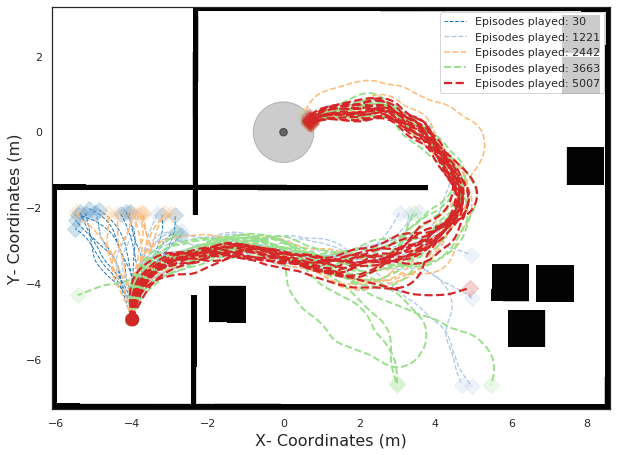

In [8]:
import seaborn as sns
sns.set_theme(style="white")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

img = plt.imread("background_env3.png")
ax.imshow(img, extent=[-6.1, 8.6, -7.3, 3.3])

ax.set_xlabel('X- Coordinates (m)', fontsize=16)
ax.set_ylabel('Y- Coordinates (m)', fontsize=16)

ax.set_xlim([-6.1, 8.6])
ax.set_ylim([-7.3, 3.3])

def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(120)

thickness = 1.0
for i, (checkpoint_key, checkpoint_value) in enumerate(trajectories.items()):
    line = None
    for run_key, run_value in checkpoint_value.items():
        x_s = [e[0] for e in run_value]
        y_s = [e[1] for e in run_value]
        starting_point = (x_s[0], y_s[0])
        ending_point = (x_s[-1], y_s[-1])
        ax.plot(*starting_point, marker='o', markersize=12, c=cmap(i * 10), alpha=0.2)
        ax.plot(*ending_point, marker='D', markersize=12, c=cmap(i * 10), alpha=0.2)
        line, = ax.plot(x_s, y_s, linestyle='dashed', linewidth=thickness, c=cmap(i * 10))
    line.set_label('Episodes played: {}'.format(int(checkpoints[i]*30.5305)))
    thickness += 0.3

ending_point = plt.Circle((0., 0.), 0.1, alpha=0.5, color='black')
ax.add_patch(ending_point)
ending_tolerance = plt.Circle((0., 0.), 0.8, alpha=0.2, color='black')
ax.add_patch(ending_tolerance)

for i, (checkpoint_key, checkpoint_value) in enumerate(success_rate.items()):
    results = 0.0
    for _, success in checkpoint_value.items():
        results += int(success)
    print('Episode: {}, Success Rate: {:10.2f}%'.format(int(checkpoints[i]*30.1658), (results/15.)*100.))

ax.legend()
plt.savefig('training_traj_train.png', dpi=300)

Episode: 30, Success Rate:       0.00%
Episode: 1206, Success Rate:      26.67%
Episode: 2413, Success Rate:      20.00%
Episode: 3619, Success Rate:      40.00%
Episode: 4947, Success Rate:      13.33%


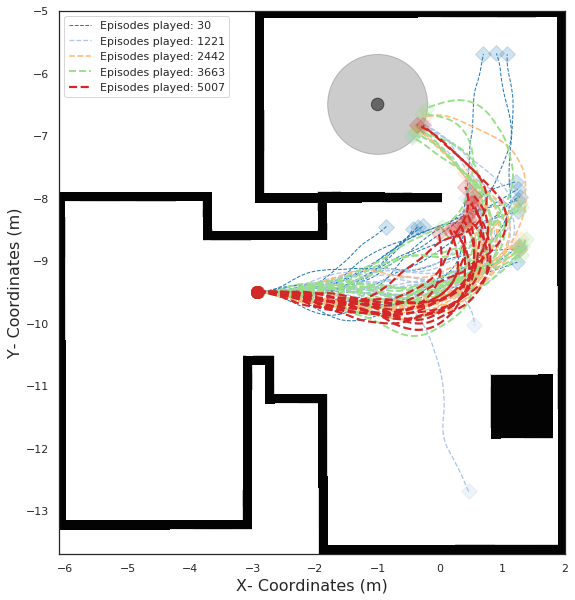

In [28]:
import seaborn as sns
sns.set_theme(style="white")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

img = plt.imread("background_env4.png")
ax.imshow(img, extent=[-6.1, 2.0, -13.7, -5.0])

ax.set_xlabel('X- Coordinates (m)', fontsize=16)
ax.set_ylabel('Y- Coordinates (m)', fontsize=16)

#ax.set_xlim([-6.1, 8.6])
#ax.set_ylim([-7.3, 3.3])

def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(120)

thickness = 1.0
for i, (checkpoint_key, checkpoint_value) in enumerate(trajectories.items()):
    line = None
    for run_key, run_value in checkpoint_value.items():
        x_s = [e[0] for e in run_value]
        y_s = [e[1] for e in run_value]
        starting_point = (x_s[0], y_s[0])
        ending_point = (x_s[-1], y_s[-1])
        ax.plot(*starting_point, marker='o', markersize=12, c=cmap(i * 10), alpha=0.2)
        ax.plot(*ending_point, marker='D', markersize=12, c=cmap(i * 10), alpha=0.2)
        line, = ax.plot(x_s, y_s, linestyle='dashed', linewidth=thickness, c=cmap(i * 10))
    line.set_label('Episodes played: {}'.format(int(checkpoints[i]*30.5305)))
    thickness += 0.3

ending_point = plt.Circle((-1.0, -6.5), 0.1, alpha=0.5, color='black')
ax.add_patch(ending_point)
ending_tolerance = plt.Circle((-1.0, -6.5), 0.8, alpha=0.2, color='black')
ax.add_patch(ending_tolerance)

for i, (checkpoint_key, checkpoint_value) in enumerate(success_rate.items()):
    results = 0.0
    for _, success in checkpoint_value.items():
        results += int(success)
    print('Episode: {}, Success Rate: {:10.2f}%'.format(int(checkpoints[i]*30.1658), (results/15.)*100.))

ax.legend()
plt.savefig('training_traj_eval.png', dpi=300)

In [8]:
o = env.observation_space.sample()
action = agent.compute_action(o)
action

1

In [9]:
policy = agent.get_policy()
model = policy.model.base_model
obs = env.reset()
for i in range(4):
    obs, _, _, _ = env.step(1)
preprocessed = agent.workers.local_worker().preprocessors[
            "default_policy"].transform(obs)
filtered_obs = agent.workers.local_worker().filters["default_policy"](
    preprocessed, update=False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observations (InputLayer)       [(None, 84, 84, 4)]  0                                            
__________________________________________________________________________________________________
conv_value_1 (Conv2D)           (None, 42, 42, 16)   592         observations[0][0]               
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 42, 42, 16)   592         observations[0][0]               
__________________________________________________________________________________________________
conv_value_2 (Conv2D)           (None, 21, 21, 32)   4640        conv_value_1[0][0]               
______________________________________________________________________________________________

In [10]:
weights = policy.get_weights()
print(weights.keys())

odict_keys(['default_policy/conv_value_1/kernel', 'default_policy/conv_value_1/bias', 'default_policy/conv1/kernel', 'default_policy/conv1/bias', 'default_policy/conv_value_2/kernel', 'default_policy/conv_value_2/bias', 'default_policy/conv2/kernel', 'default_policy/conv2/bias', 'default_policy/conv_value_3/kernel', 'default_policy/conv_value_3/bias', 'default_policy/conv3/kernel', 'default_policy/conv3/bias', 'default_policy/conv_value_4/kernel', 'default_policy/conv_value_4/bias', 'default_policy/conv4/kernel', 'default_policy/conv4/bias', 'default_policy/conv_value_out/kernel', 'default_policy/conv_value_out/bias', 'default_policy/conv_out/kernel', 'default_policy/conv_out/bias'])


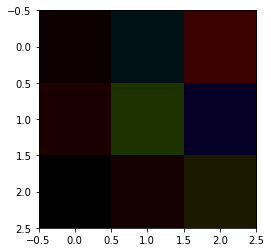

In [11]:
plt.imshow(weights['default_policy/conv1/kernel'][:, :, 0:3, 2])

In [12]:
import tensorflow as tf

In [14]:
inputs = tf.keras.Input(shape=(84, 84, 4,))
x = tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same', name='conv1')(inputs)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', name='conv2')(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', name='conv3')(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2D(128, (11, 11), strides=(1, 1), padding='valid', name='conv4')(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2D(3, (1, 1), strides=(1, 1), padding='valid', name='conv_out')(x)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile(loss='mse')
model.summary()

model.layers[1].set_weights([weights['default_policy/conv1/kernel'], weights['default_policy/conv1/bias']])
model.layers[3].set_weights([weights['default_policy/conv2/kernel'], weights['default_policy/conv2/bias']])
model.layers[5].set_weights([weights['default_policy/conv3/kernel'], weights['default_policy/conv3/bias']])
model.layers[7].set_weights([weights['default_policy/conv4/kernel'], weights['default_policy/conv4/bias']])
model.layers[9].set_weights([weights['default_policy/conv_out/kernel'], weights['default_policy/conv_out/bias']])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 84, 84, 4)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 42, 42, 16)        592       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 42, 42, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 21, 21, 32)        4640      
_________________________________________________________________
re_lu_5 (ReLU)               (None, 21, 21, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 11, 11, 64)        18496     
_________________________________________________________________
re_lu_6 (ReLU)               (None, 11, 11, 64)        0   

In [251]:
inputs = tf.keras.Input(shape=(84, 84, 4,))
x = tf.keras.layers.Conv2D(16, (8, 8), strides=(4, 4), padding='same', name='conv1')(inputs)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same', name='conv2')(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2D(256, (11, 11), strides=(1, 1), padding='valid', name='conv3')(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2D(3, (1, 1), strides=(1, 1), padding='valid', name='conv_out')(x)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile(loss='mse')
model.summary()

model.layers[1].set_weights([weights['default_policy/conv1/kernel'], weights['default_policy/conv1/bias']])
model.layers[3].set_weights([weights['default_policy/conv2/kernel'], weights['default_policy/conv2/bias']])
model.layers[5].set_weights([weights['default_policy/conv3/kernel'], weights['default_policy/conv3/bias']])
model.layers[7].set_weights([weights['default_policy/conv_out/kernel'], weights['default_policy/conv_out/bias']])

Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 84, 84, 4)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 21, 21, 16)        4112      
_________________________________________________________________
re_lu_66 (ReLU)              (None, 21, 21, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 11, 11, 32)        8224      
_________________________________________________________________
re_lu_67 (ReLU)              (None, 11, 11, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 1, 1, 256)         991488    
_________________________________________________________________
re_lu_68 (ReLU)              (None, 1, 1, 256)         0  

In [252]:
for key, value in weights.items():
    print(key)
    print(value.shape)
    print("----------")

default_policy/conv_value_1/kernel
(8, 8, 4, 16)
----------
default_policy/conv_value_1/bias
(16,)
----------
default_policy/conv1/kernel
(8, 8, 4, 16)
----------
default_policy/conv1/bias
(16,)
----------
default_policy/conv_value_2/kernel
(4, 4, 16, 32)
----------
default_policy/conv_value_2/bias
(32,)
----------
default_policy/conv2/kernel
(4, 4, 16, 32)
----------
default_policy/conv2/bias
(32,)
----------
default_policy/conv_value_3/kernel
(11, 11, 32, 256)
----------
default_policy/conv_value_3/bias
(256,)
----------
default_policy/conv3/kernel
(11, 11, 32, 256)
----------
default_policy/conv3/bias
(256,)
----------
default_policy/conv_value_out/kernel
(1, 1, 256, 1)
----------
default_policy/conv_value_out/bias
(1,)
----------
default_policy/conv_out/kernel
(1, 1, 256, 3)
----------
default_policy/conv_out/bias
(3,)
----------


In [254]:
model.layers


In [22]:
preprocessed = agent.workers.local_worker().preprocessors["default_policy"].transform(obs)
filtered_obs = agent.workers.local_worker().filters["default_policy"](preprocessed, update=False)

conv_1 = tf.keras.Model(inputs=model.layers[0].input, outputs=model.layers[2].output)
conv_2 = tf.keras.Model(inputs=model.layers[0].input, outputs=model.layers[4].output)
conv_3 = tf.keras.Model(inputs=model.layers[0].input, outputs=model.layers[6].output)
pred_1 = conv_1.predict(filtered_obs.reshape(1, 84, 84, 4))
pred_2 = conv_2.predict(filtered_obs.reshape(1, 84, 84, 4))
pred_3 = conv_3.predict(filtered_obs.reshape(1, 84, 84, 4))
pred_3.shape

/home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


(1, 11, 11, 64)

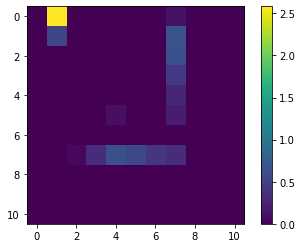

In [71]:
#plt.imshow(obs[:, :, 0])
#np.save('obs_learning.npy', obs)
plt.imshow(pred_3[0, :, :, 11])
plt.colorbar()

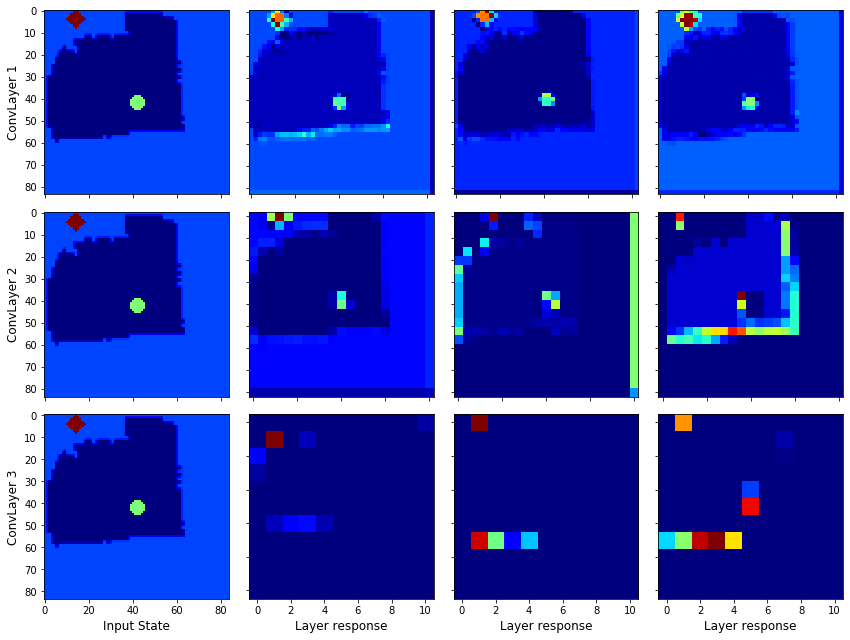

In [74]:
import numpy as np
obs = np.load('obs_learning.npy')
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))

cols = ['{}'.format(col) for col in ['Input State', 'Layer response', 'Layer response', 'Layer response']]
rows = ['ConvLayer {}'.format(row) for row in range(1, 4)]

for i in range(3):
    axes[i, 0].imshow(obs[:, :, 0], vmin=0., vmax=1., cmap='jet')

for i, kernel in enumerate([0, 7, 15]):
    axes[0, 1+i].imshow(pred_1[0, :, :, kernel], cmap='jet')

for i, kernel in enumerate([1, 6, 12]):
    axes[1, 1+i].imshow(pred_2[0, :, :, kernel], cmap='jet')

for i, kernel in enumerate([7, 11, 12]):
    axes[2, 1+i].imshow(pred_3[0, :, :, kernel], cmap='jet')

for ax in axes.flat:
    ax.label_outer()

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

plt.setp(axes[-1, 1:], xlabel='Layer response')

for i, col in enumerate(cols):
    axes[-1, i].set_xlabel(col, size=12)

plt.tight_layout()
plt.savefig('layer_respones.png', dpi=300)

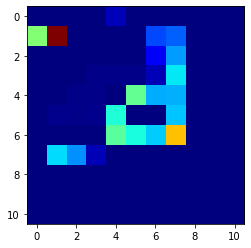

In [317]:
plt.imshow(pred_2[0, :, :, 22], cmap='jet')

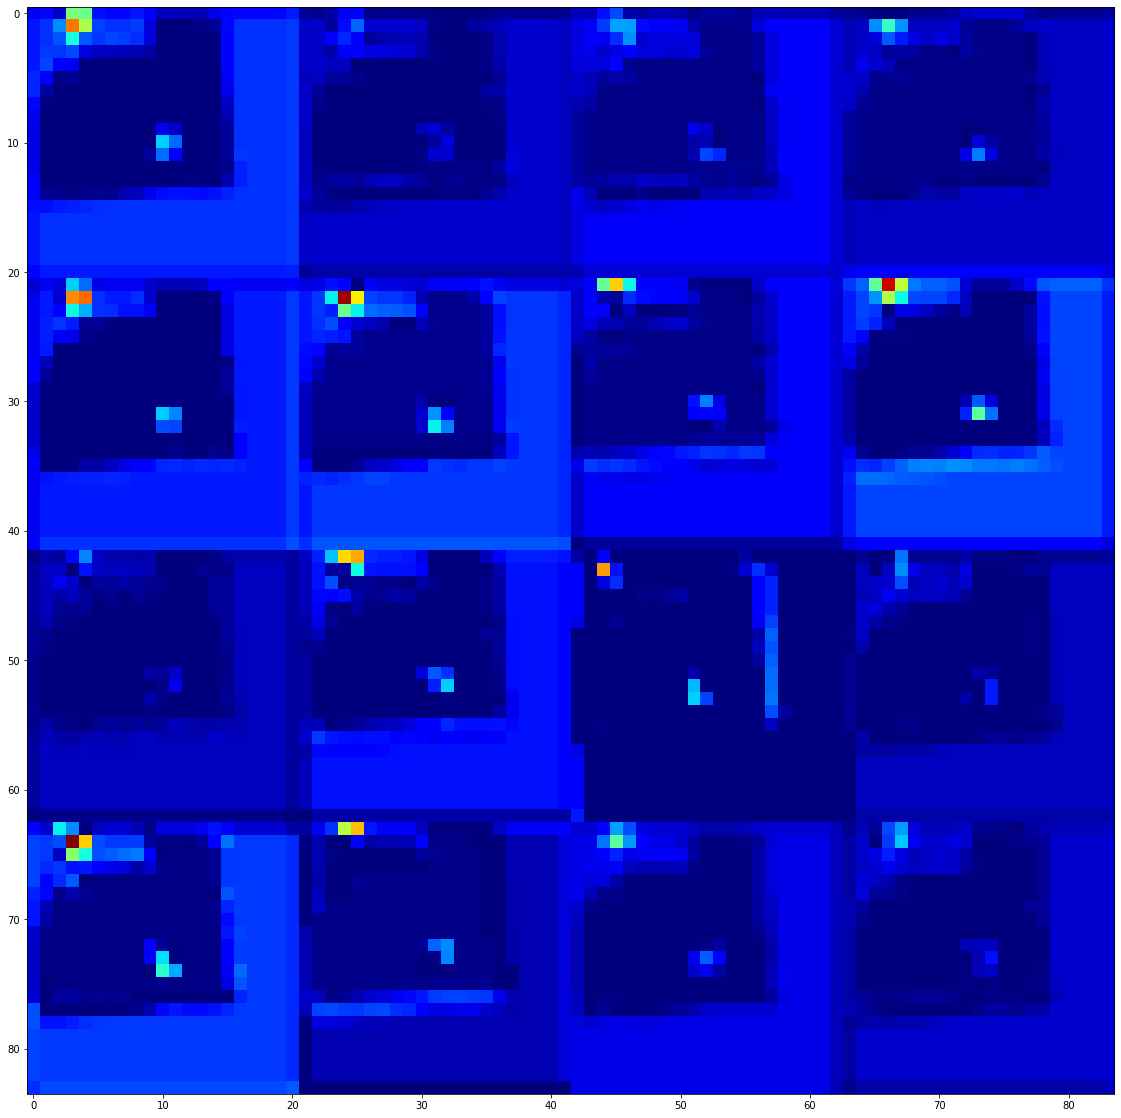

In [270]:
import numpy as np
shape = 21
height = 4
width = 4
activations = np.zeros((shape*height, shape*width))
k = 0
for i in range(height):
    for j in range(width):
        activations[shape*i:shape*(i+1), shape*j:shape*(j+1)] = pred_1[0, :, :, k]
        k += 1

plt.figure(figsize=(20, 20))
plt.imshow(activations, cmap='jet')

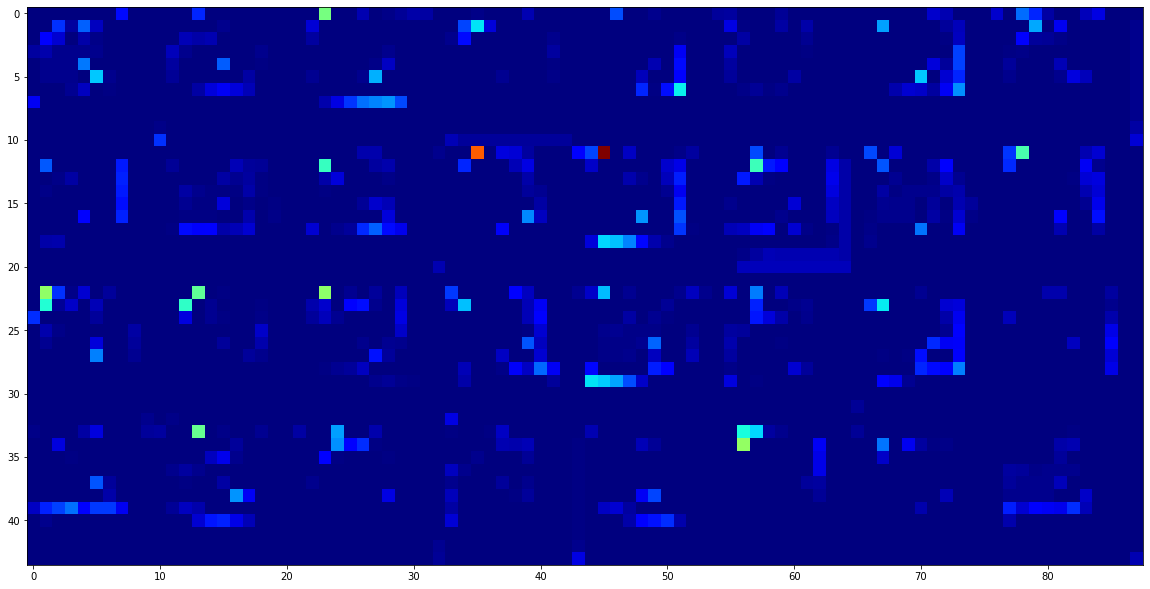

In [271]:
import numpy as np
shape = 11
height = 4
width = 8
activations = np.zeros((shape*height, shape*width))
k = 0
for i in range(height):
    for j in range(width):
        activations[shape*i:shape*(i+1), shape*j:shape*(j+1)] = pred_2[0, :, :, k]
        k += 1

plt.figure(figsize=(20, 20))
plt.imshow(activations, cmap='jet')

In [320]:
tmp = np.zeros((21, 21))
for i in range(16):
    tmp += pred_1[0, :, :, i]

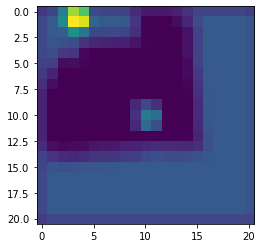

In [321]:
plt.imshow(tmp)